In [1]:
#type this into the commandline (make sure you're in the right directory)
#mongoexport --db venmo --collection venmo --type=csv --out notes.csv --fields note
import numpy as np
import pandas as pd
import gensim 
import string
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
from gensim.models import Word2Vec
from collections import Counter
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv("notes.csv")

In [3]:
df = df.dropna()

In [4]:
#break the df into chunks
n = 250000  #chunk row size
df_list = [df[i:i+n] for i in range(0,df.shape[0],n)]
df_list[0] #currently I'm going to work on one chunk only

,note
0,fuk ya
1,🚗
2,:venmo_dollar:
3,Gatorade
4,🎉
...,...
250000,Letting me try on 7 pairs 😎
250001,Fight night 🥊
250002,Big nonsense
250003,Food


In [5]:
corpus = []
for index, row in df_list[0].iterrows():
    note = [word.lower() for word in row["note"].split()]
    corpus.append(note)

In [6]:
model = Word2Vec(corpus, size=100, window=5, min_count=1, workers=4)

In [7]:
#extract feature vector from notes
feature_list = []
for index, row in df_list[0].iterrows():
    note = [word.lower() for word in row["note"].split()]
    for word in note:
        feature = []
        feature.append(model.wv[word])
    feature_list.append(np.average(feature,axis=0))

In [8]:
#split the notes into clusters (still not sure of optimal cluster count)
kmeans = KMeans(n_clusters=13)
kmeans.fit(feature_list)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [9]:
Counter(kmeans.labels_)

Counter({11: 1087,
         6: 9416,
         1: 35713,
         2: 125232,
         10: 46004,
         5: 12914,
         0: 3917,
         4: 8835,
         7: 888,
         12: 3447,
         8: 1088,
         3: 406,
         9: 1053})

In [10]:
pd.options.mode.chained_assignment = None
df_list[0]["label"] = kmeans.labels_

In [11]:
df_list[0]

,note,label
0,fuk ya,11
1,🚗,6
2,:venmo_dollar:,1
3,Gatorade,2
4,🎉,1
...,...,...
250000,Letting me try on 7 pairs 😎,1
250001,Fight night 🥊,2
250002,Big nonsense,2
250003,Food,5


In [12]:
#this function generates a list of common words based on the cluster number you give it (0,1,2,etc.)
def common_words(cluster_num):
    cluster = []
    stop_words = set(stopwords.words('english'))
    for index, row in df_list[0].iterrows():
        if row["label"] == cluster_num:
            note = [word.lower() for word in row["note"].split()]
            for word in note:
                if word not in stop_words:
                    cluster.append(word)
    print("Cluster " + str(cluster_num) + ":")
    print(Counter(cluster).most_common(10))

In [13]:
for i in range(13):
    common_words(i)

Cluster 0:
[('rent', 1701), ('august', 735), ('bill', 604), ('2', 458), ('july', 450), ('deposit', 413), ('1', 270), ('part', 190), ('gas', 120), ('security', 119)]
Cluster 1:
[('🍕', 2282), ('🍺', 1506), ('⛽', 1324), ('🍴', 1192), ('🍻', 990), ('🍹', 846), (':venmo_dollar:', 689), ('🍷', 662), ('🍔', 643), ('⛳', 632)]
Cluster 2:
[('thanks', 678), ('thank', 654), ('+', 610), ('&', 580), ('rent', 465), ('-', 453), ('july', 410), ('love', 406), ('last', 392), ('uber', 390)]
Cluster 3:
[('u', 412), ('love', 97), ('thank', 72), ('luv', 36), ('hate', 12), ('f', 11), ('thx', 10), ('miss', 10), ('like', 7), ('luh', 6)]
Cluster 4:
[('❤️', 1185), ('😘', 890), (':)', 787), ('lunch', 536), ('lol', 445), ('💕', 433), ('life', 382), ('gift', 238), ('thx', 207), ('b', 202)]
Cluster 5:
[('food', 3612), ('uber', 2262), ('stuff', 1242), ('dinner', 607), ('gas', 512), ('drinks', 502), ('tip', 391), ('pizza', 341), ('fee', 339), ('night', 316)]
Cluster 6:
[('🏠💸', 2568), ('🏠', 1197), ('🚗', 1027), ('🏡', 667), ('wif

In [14]:
#this function generates a wordcloud based on the cluster number you give it (0,1,2,etc.)
def create_cluster_cloud(cluster_num):
    # the regex used to detect words is a combination of normal words, ascii art, and emojis
    # 2+ consecutive letters (also include apostrophes), e.x It's
    normal_word = r"(?:\w[\w']+)"
    # 2+ consecutive punctuations, e.x. :)
    ascii_art = r"(?:[{punctuation}][{punctuation}]+)".format(punctuation=string.punctuation)
    # a single character that is not alpha_numeric or other ascii printable
    emoji = r"(?:[^\s])(?<![\w{ascii_printable}])".format(ascii_printable=string.printable)
    regexp = r"{normal_word}|{ascii_art}|{emoji}".format(normal_word=normal_word, ascii_art=ascii_art, emoji=emoji)
    stopwords = set(STOPWORDS)
    cluster = ' '
    for index, row in df_list[0].iterrows():
        if row["label"] == cluster_num:
            note = [word.lower() for word in row["note"].split()]
            for word in note:
                cluster = cluster + word + ' '
    wordcloud = WordCloud(font_path = "Symbola.ttf", width=1000, height=1000, stopwords = stopwords, regexp = regexp).generate(cluster)
    plt.figure(figsize = (10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show() 

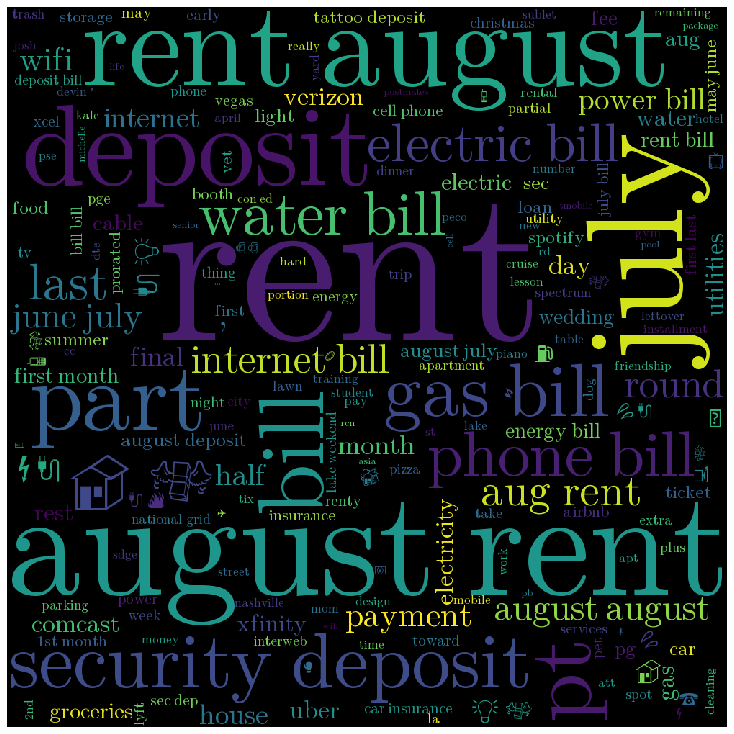

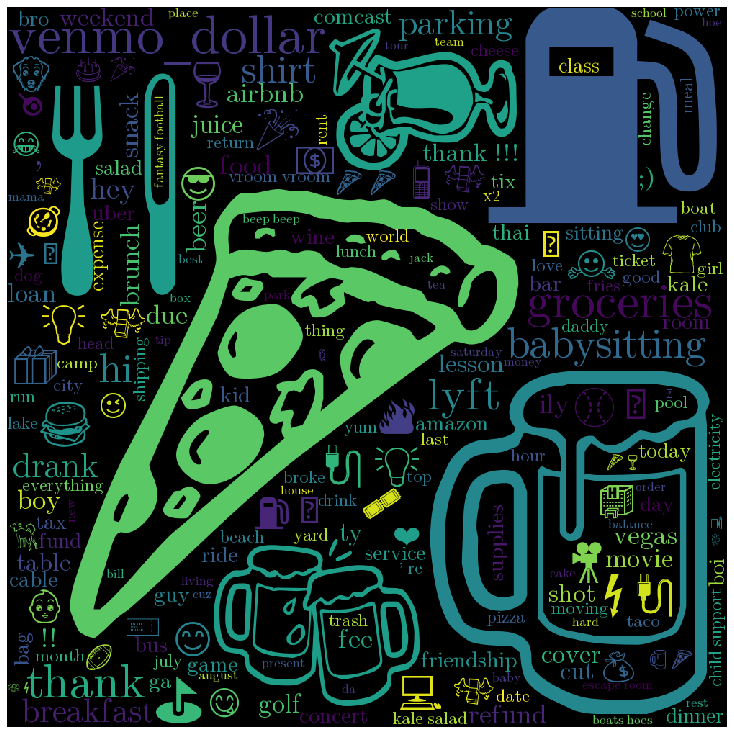

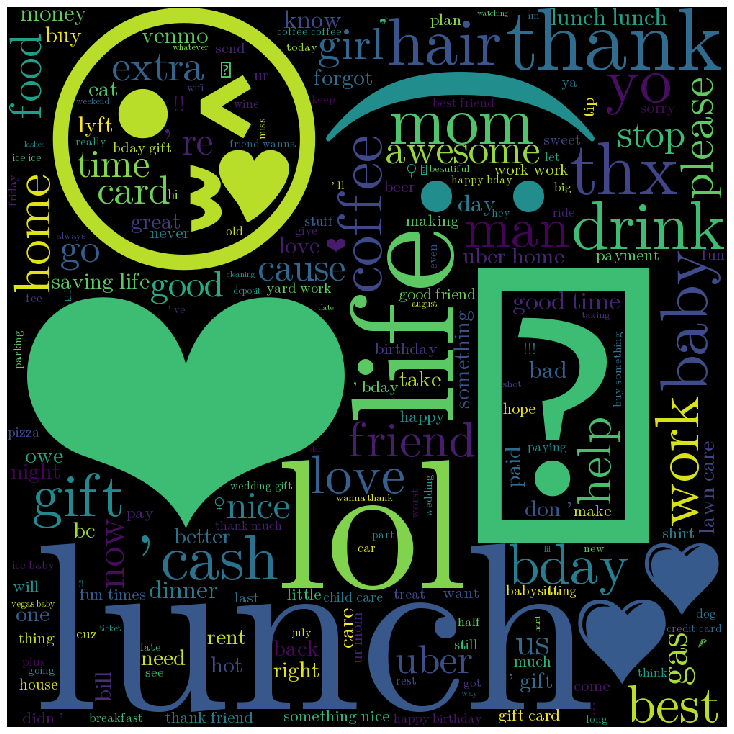

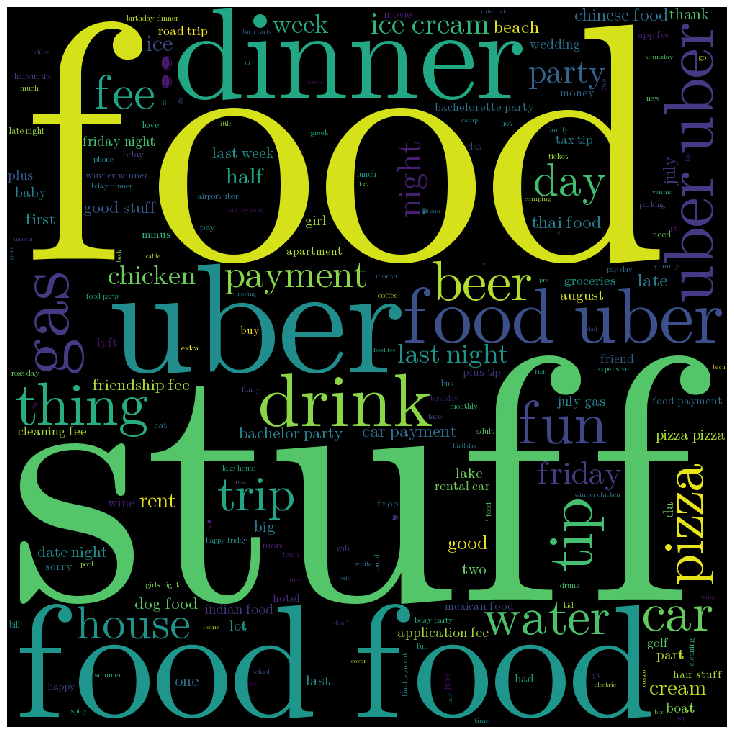

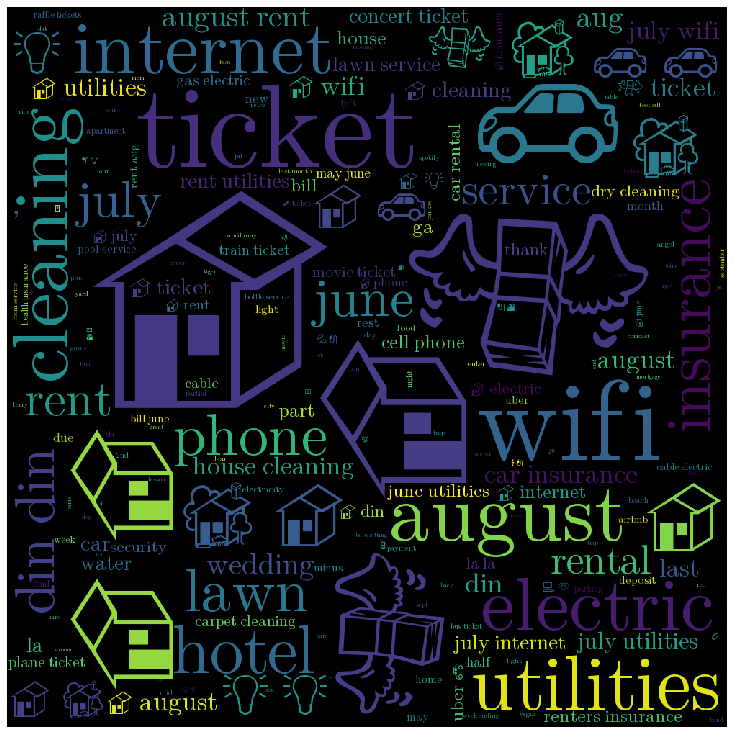

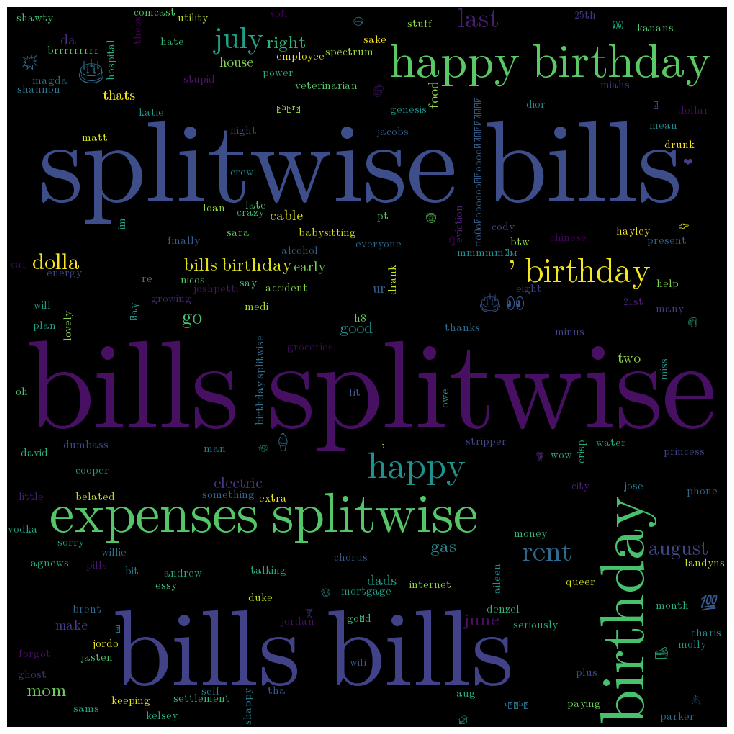

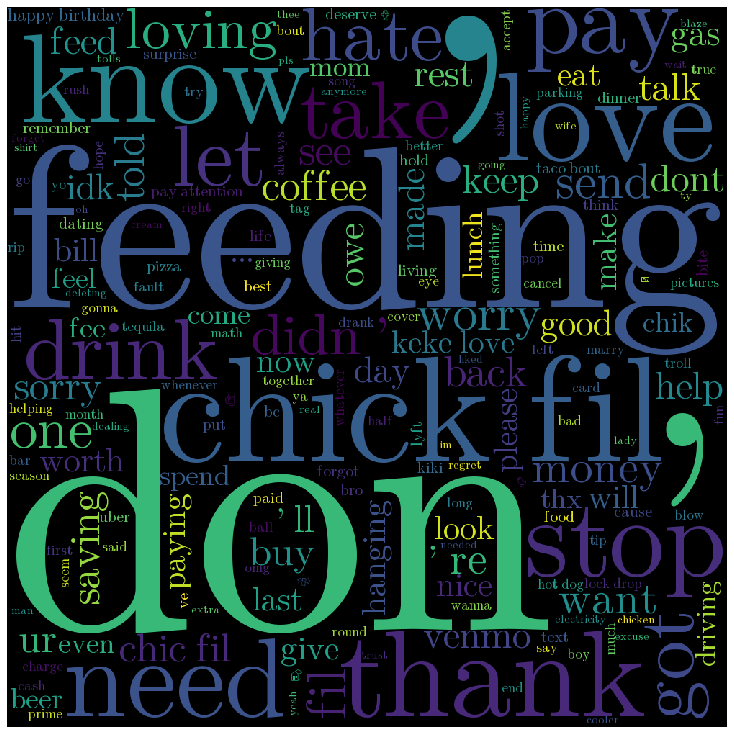

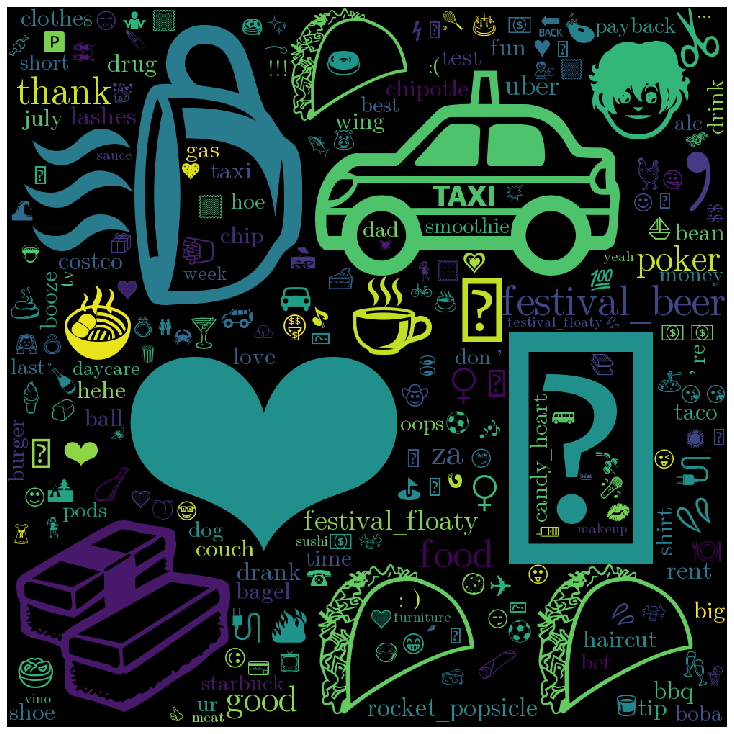

In [16]:
create_cluster_cloud(0)
create_cluster_cloud(1)
create_cluster_cloud(4)
create_cluster_cloud(5)
create_cluster_cloud(6)
create_cluster_cloud(8)
create_cluster_cloud(9)
create_cluster_cloud(10)